In [5]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.style.use("seaborn-colorblind")


# only displays the most important warnings
tf.logging.set_verbosity(tf.logging.FATAL)

In [7]:
used_features = ['property_type','room_type','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count'
                ,'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit','host_is_superhost',
                 'instant_bookable', 'price']

boston = pd.read_csv(r"C:\Users\Urvashi\Desktop\New folder\Urvashi\Datasets\Kaggle_Boston_Airbnb\listings.csv",usecols=used_features)

In [8]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 17 columns):
host_is_superhost            3585 non-null object
host_total_listings_count    3585 non-null int64
neighbourhood_cleansed       3585 non-null object
property_type                3582 non-null object
room_type                    3585 non-null object
accommodates                 3585 non-null int64
bathrooms                    3571 non-null float64
bedrooms                     3575 non-null float64
beds                         3576 non-null float64
bed_type                     3585 non-null object
price                        3585 non-null object
security_deposit             1342 non-null object
cleaning_fee                 2478 non-null object
minimum_nights               3585 non-null int64
number_of_reviews            3585 non-null int64
review_scores_value          2764 non-null float64
instant_bookable             3585 non-null object
dtypes: float64(4), int64(4), object(9)
mem

In [9]:
boston.shape

(3585, 17)

In [10]:
boston.isnull().sum()

host_is_superhost               0
host_total_listings_count       0
neighbourhood_cleansed          0
property_type                   3
room_type                       0
accommodates                    0
bathrooms                      14
bedrooms                       10
beds                            9
bed_type                        0
price                           0
security_deposit             2243
cleaning_fee                 1107
minimum_nights                  0
number_of_reviews               0
review_scores_value           821
instant_bookable                0
dtype: int64

In [11]:
type(boston["price"])

pandas.core.series.Series

In [12]:
for feature in ["cleaning_fee","security_deposit","price"]:
    boston[feature] = boston[feature].map(lambda x:x.replace("$",'').replace(",",''),na_action = 'ignore')
    boston[feature] = boston[feature].astype(float)
    boston[feature].fillna(boston[feature].median(),inplace = True)

In [13]:
for feature in ["bathrooms","bedrooms","beds","review_scores_value"]:
    boston[feature].fillna(boston[feature].median(),inplace = True)

In [14]:
boston["property_type"].value_counts()

# since property_type has appeared the max no. of times. we will fill the NUll values with it.

boston['property_type'].fillna('Apartment',inplace = True)

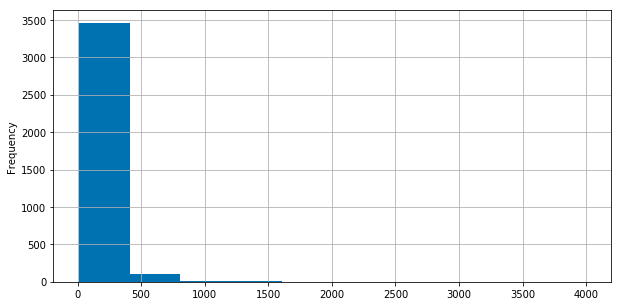

In [15]:
#Before moving on to the other features, we check our target variable price.

boston["price"].plot(kind="hist",grid = True,figsize = (10,5))

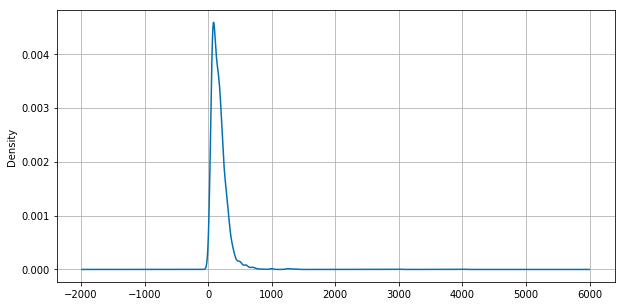

In [16]:
boston["price"].plot(kind="kde",grid = True,figsize = (10,5))

In [17]:
boston['price'].skew()

8.5214835656839512

Prices are heavily skewed in this dataset. In the histogram we can also see most of the data falls under 500. So we’ll use a subset of our dataset where the price ranges from 50–500 for now to remove very large and very small prices. We’ll also log-transform the target variable to reduce skewness.

In [18]:
boston = boston[(boston["price"] > 50) & (boston["price"] < 500)]

In [19]:
boston.shape

(3269, 17)

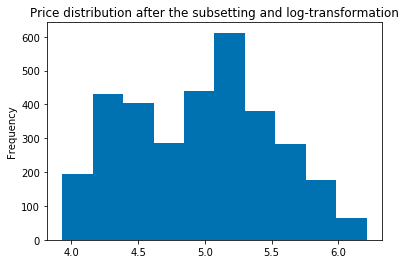

In [20]:
target = np.log(boston["price"])

plt.title("Price distribution after the subsetting and log-transformation");
target.plot(kind = "hist")

In [21]:
features = boston.drop('price',axis=1)
features.head()

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,35.0,2,0,9.0,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,95.0,10.0,2,36,9.0,t
2,t,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,250.0,50.0,3,41,10.0,f
3,f,1,Roslindale,House,Private room,4,1.0,1.0,2.0,Real Bed,100.0,50.0,1,1,10.0,f
4,t,1,Roslindale,House,Private room,2,1.5,1.0,2.0,Real Bed,250.0,15.0,2,29,10.0,f


In [22]:
features["host_total_listings_count"].value_counts()
# numeric column

1      1464
2       458
3       189
4       142
749     136
558      79
5        77
7        77
363      58
313      55
6        55
11       53
52       50
24       48
18       28
22       27
8        26
307      25
12       24
30       24
13       22
15       22
16       21
37       20
21       17
20       14
10       14
122      13
14       10
28        8
17        5
9         4
0         2
71        1
45        1
Name: host_total_listings_count, dtype: int64

### Split the data into train and test set

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2190, 16)
(2190,)
(1079, 16)
(1079,)


## Generating Feature Columns for Processing into DNN_LinearCombinedRegressor Estimator

First we’ll separate the column names of the numeric features and the categorical features.

[Link](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html)

In [25]:
# Get all the numeric feature names

numeric_columns = ['host_total_listings_count','accommodates','bathrooms','bedrooms','beds',
 'security_deposit','cleaning_fee','minimum_nights','number_of_reviews',
 'review_scores_value']

# Get all the categorical feature names that contains strings
categorical_columns = ['host_is_superhost','neighbourhood_cleansed','property_type','room_type','bed_type','instant_bookable']

In [26]:
# Numeric Feature Columns

numeric_features = [tf.feature_column.numeric_column(key = column) for column in numeric_columns]
print(numeric_features)

[_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='accommodates', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='bathrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='beds', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='security_deposit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='cleaning_fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='minimum_nights', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='number_of_reviews', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='review_scores_va

**Note : DNN_Linear_Combined_Regressor takes both types of feature_cols i.e. Linear and Dense.So, here we can pass Linear cols(such as categorical ones) separately and Dense cols (such as Numerical ones) separately**


In [27]:
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key=column
                            ,vocabulary_list=features[column].unique()) for column in categorical_columns]

print(categorical_features[0])

_VocabularyListCategoricalColumn(key='host_is_superhost', vocabulary_list=('f', 't'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


In [32]:
# Create training input function

training_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=32,shuffle=True,num_epochs=None)

# create testing input function

testing_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=32,shuffle=False,num_epochs=1)


### Instantiate Model


In [38]:
model = tf.estimator.DNNLinearCombinedRegressor(linear_feature_columns=categorical_features,
                                                dnn_feature_columns=numeric_features,dnn_hidden_units=[100,100])

# note : this is only a Single Layer Linear_Regressor.

### Train the Model

We pass the training_input_fn to the input_fn parameter of the train method and specify the number of steps we want to train the model. Note that we have to pass the function object(input_fn = training_input_fn) to the input_fn parameter, not the return value of the function call.(input_fn = training_input_fn()).

In [39]:
model.train(input_fn=training_input_fn,steps=10000)

### Evaluate model on Testing Dataset

In [40]:
model.evaluate(input_fn=testing_input_fn)

{'average_loss': 0.25732416, 'global_step': 10000, 'loss': 8.1662579}

### Making Predictions on Testing Dataset

In [41]:
model.predict(input_fn=testing_input_fn)

# this gives a generator object, which we need to typecast 

<generator object Estimator.predict at 0x0000016181197518>

In [42]:
pred = list(model.predict(input_fn = testing_input_fn))
pred

[{'predictions': array([ 4.72208929], dtype=float32)},
 {'predictions': array([ 4.35005283], dtype=float32)},
 {'predictions': array([ 4.81083918], dtype=float32)},
 {'predictions': array([ 4.75035286], dtype=float32)},
 {'predictions': array([ 4.24581432], dtype=float32)},
 {'predictions': array([ 4.97203207], dtype=float32)},
 {'predictions': array([ 5.16723394], dtype=float32)},
 {'predictions': array([ 6.24869442], dtype=float32)},
 {'predictions': array([ 4.6004982], dtype=float32)},
 {'predictions': array([ 4.50301456], dtype=float32)},
 {'predictions': array([ 5.25234795], dtype=float32)},
 {'predictions': array([ 4.24838018], dtype=float32)},
 {'predictions': array([ 5.37822008], dtype=float32)},
 {'predictions': array([ 4.96632814], dtype=float32)},
 {'predictions': array([ 4.60246611], dtype=float32)},
 {'predictions': array([ 5.43049765], dtype=float32)},
 {'predictions': array([ 4.50547791], dtype=float32)},
 {'predictions': array([ 4.56600952], dtype=float32)},
 {'predicti

In [43]:
pred = [p['predictions'][0] for p in pred]
print(pred)

[4.7220893, 4.3500528, 4.8108392, 4.7503529, 4.2458143, 4.9720321, 5.1672339, 6.2486944, 4.6004982, 4.5030146, 5.2523479, 4.2483802, 5.3782201, 4.9663281, 4.6024661, 5.4304976, 4.5054779, 4.5660095, 5.2020035, 4.7702618, 6.1291089, 5.2724142, 4.514575, 4.3301883, 6.0005851, 4.4858503, 4.050868, 5.1791573, 4.993937, 4.5121655, 5.2398257, 4.2879658, 4.5013876, 4.0284672, 4.2976122, 4.7921071, 5.3318353, 4.5901642, 5.5030603, 4.4268546, 5.7061582, 5.7412314, 4.7221622, 4.9262929, 4.9827142, 4.0336866, 4.9291353, 6.314568, 4.2147498, 4.8634567, 4.3747725, 5.3173332, 4.9718256, 5.1094871, 5.3801422, 3.8394465, 4.5274472, 4.3944454, 4.8708777, 4.2103314, 4.2588954, 3.9817927, 4.8634424, 5.7105494, 5.5252757, 5.2724142, 4.8985167, 5.7354641, 4.4041748, 4.6797266, 5.3215442, 4.9800582, 4.3586745, 4.5460343, 4.4707465, 4.9371414, 5.0203366, 4.5901136, 5.5975938, 4.7169952, 4.4960871, 4.710175, 5.8335123, 4.2464304, 4.8384748, 4.3960423, 4.9830556, 4.8858633, 4.8332634, 5.5892677, 4.4508152, 4.5

Since we had log-transformed the price before we’ve to use the exponential function to inverse it and get our prices for the rental values in original dollar terms.

In [45]:
prices = np.exp(pred)
print(prices)

[ 112.40284729   77.4825592   122.83465576 ...,  109.47668457  110.71092224
  122.29685211]
